# Интеллектуальный анализ данных – весна 2025

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов.


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
def my_entropy(Data: np.array) -> float:
    E = 0
    for c in np.unique(Data):
        p = Data[Data==c].shape[0]/Data.shape[0]
        E += p*np.log(p)
    return(-E)

In [3]:
entropy = my_entropy(np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2]))
print(round(entropy, 2))

0.5


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
def my_gini_impurity(Data: np.array) -> float:
    G = 0
    for c in np.unique(Data):
        p = Data[Data==c].shape[0]/Data.shape[0]
        G += p*(1-p)
    return(G)

In [5]:
h_r = my_gini_impurity(np.array([1, 1, 1, 1, 1, 1, 1, 1, 2, 2]))
#на самом нет необходимости считать энтропии в новых вершинах, поскольку если в одной вершине будут объекты только одного класса, энтропия (то есть степень неопределенности) = 0
h_rl = my_gini_impurity(np.array([1, 1, 1, 1, 1, 1, 1, 1]))
h_rr = my_gini_impurity(np.array([2, 2]))

#не нормирую на размер поддерева, так как в любом случае получается 0
q_inform = h_r - h_rl - h_rr
print(round(q_inform, 2))

0.32


источник: https://insidelearningmachines.com/gini_impurity/

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [6]:
def my_mean(Data: np.array) -> float:
    D = sum(Data) / len(Data)
    return(D)

In [7]:
my_mean(np.array([1, 10, 5, 18, 100, 30, 50, 61, 84, 47]))

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [8]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [9]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    feature_vector = np.asarray(feature_vector).flatten()
    target_vector = np.asarray(target_vector).flatten()

    #проверим, не константный ли признак
    if len(np.unique(feature_vector)) <= 1:
        return np.array([]), np.array([]), None, None

    #создадим пороги
    if feature_type == "real":
        feature_sorted = np.sort(np.unique(feature_vector))
        thresholds = 0.5*(feature_sorted[1:] + feature_sorted[:-1])
    else:
        thresholds = np.sort(np.unique(feature_vector))

    # создадим маски для левого дерева
    if feature_type == "real":
        left_masks = feature_vector[:, None] <= thresholds
    else:
        left_masks = feature_vector[:, None] == thresholds
    
    # и сразу посчитаем размеры деревьев
    left_sizes = np.sum(left_masks, axis=0)
    right_sizes = len(feature_vector) - left_sizes
    
    # нам нужно убрать из рассмотрения случаи, где в поддере содержится пустое множество объектов
    valid_mask = (left_sizes > 0) & (right_sizes > 0)
    
    thresholds = thresholds[valid_mask]
    left_masks = left_masks[:, valid_mask]
    left_sizes = left_sizes[valid_mask]
    right_sizes = right_sizes[valid_mask]
    
    #если у нас не осталось порогов без пустых поддеревьев, вернем пустые объекты
    if len(thresholds) == 0:
        return np.array([]), np.array([]), None, None
    
    # посчитаем критерий информативности для задачи классификации
    if task == "classification":
        h = my_gini_impurity(target_vector)
        h_l = np.array([my_gini_impurity(target_vector[left_masks[:, i]]) for i in range(left_masks.shape[1])])
        h_r = np.array([my_gini_impurity(target_vector[~left_masks[:, i]]) for i in range(left_masks.shape[1])])
        ginis = h - (left_sizes/len(target_vector))*h_l - (right_sizes/len(target_vector))*h_r

    #теперь то же самое для регресии
    elif task == "regression":
        h = np.var(target_vector)
        h_l = np.array([np.var(target_vector[left_masks[:, i]]) for i in range(left_masks.shape[1])])
        h_r = np.array([np.var(target_vector[~left_masks[:, i]]) for i in range(left_masks.shape[1])])
        ginis = h - (left_sizes/len(target_vector))*h_l - (right_sizes/len(target_vector))*h_r

    #осталось найти лучший порог
    gini_best = np.max(ginis)
    best_thresholds = thresholds[ginis == gini_best]
    threshold_best = np.min(best_thresholds)  
    
    return thresholds, ginis, threshold_best, gini_best

источник: https://stackoverflow.com/questions/10849054/array-of-neighbor-averages

Эту функцию можно протестировать на датасете `California`.

In [10]:
from sklearn.datasets import fetch_california_housing

In [11]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [12]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

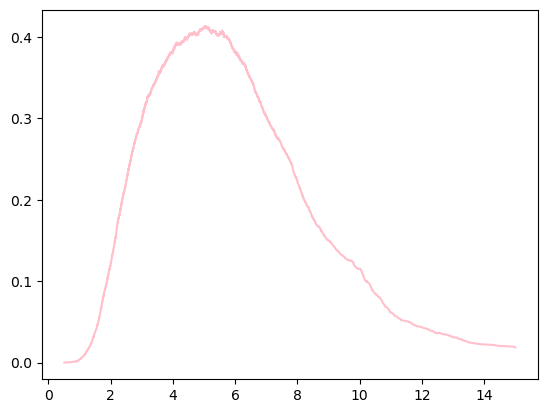

In [13]:
thresholds, ginis, threshold_best, gini_best = find_best_split(X['MedInc'], y, task = 'regression', feature_type = "real")
plt.plot(thresholds, ginis, color='pink');

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [14]:
best_pred = ''
best_gini = 0

for column in X.columns:
    thresholds, ginis, threshold_best, gini_best = find_best_split(X[column], y, task = 'regression', feature_type = "real")
    if gini_best > best_gini:
        best_gini = gini_best
        best_pred = column

print(f'лучший предикат с максимальным значением критерия информативности: {column}')

лучший предикат с максимальным значением критерия информативности: Longitude


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [82]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        #сделаем так, чтобы наш класс умел работать с пропусками
        #кажется, самый умный способ - строить небинарное дерево, где в каждом разбиении есть вариант для "да", "нет" и пропуска
        #однако, это означало бы значительное усложнение нашего алгоритма и не совсем соответствовало бы заданию
        #поэтому обработаем пропуски просто при помощи SimpleImputer
        #на многих данных такая стратегия будет вполне разумной, например, в источнике (ссылка внизу) такая стратегия предлагается как валидная
        #чтобы добавить гибкости, разрешим выбирать стратегию заполнения пропуском при вызове функции (позднее)

        self._imputer = None
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}

        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini is not None and (gini_best is None or gini > gini_best):
                feature_best = feature  
                gini_best = gini
            
                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold  
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = feature_vector == threshold 
                else:
                    raise ValueError
                    
        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
            return node['class']
        if self._feature_types[node['feature_split']] == 'real':
            if x[node['feature_split']] <= node['threshold']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        if self._feature_types[node['feature_split']] == 'categorical':
            if x[node['feature_split']] == node['category_split']:
                return self._predict_node(x, node['left_child'])
            else:
                return self._predict_node(x, node['right_child'])
        

    def fit(self, X: np.ndarray, y: np.ndarray, strategy_imputer_num: str = 'mean', strategy_imputer_cat: str = 'most_frequent') -> None:
        from sklearn.impute import SimpleImputer
        self._imputer = SimpleImputer(strategy=strategy_imputer_num)
       
        if any(ft == "categorical" for ft in self._feature_types):
            cat_imputer = SimpleImputer(strategy=strategy_imputer_cat)
            cat_cols = [i for i, ft in enumerate(self._feature_types) if ft == "categorical"]
            if cat_cols:
                cat_imputer.fit(X[:, cat_cols])
                self._cat_imputer = cat_imputer
        
        self._imputer.fit(X)
        X_imputed = self._imputer.transform(X)
        self._fit_node(X_imputed, y, self._tree)
    

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_imputed = self._imputer.transform(X)

        if hasattr(self, '_cat_imputer'):
            cat_cols = [i for i, ft in enumerate(self._feature_types) if ft == "categorical"]
            X_imputed[:, cat_cols] = self._cat_imputer.transform(X[:, cat_cols])
                    
        predicted = []
        for x in X_imputed:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

    #добавим метод оценки важности признаков
    def feature_importances(self, X_test: np.array, y_test: np.array) -> dict:
        from sklearn.metrics import accuracy_score
        import copy

        preds = self.predict(X_test)
        accuracy_before = accuracy_score(y_test, preds)
        feature_importances_dict = {}

        for i in range(X_test.shape[1]):
            X_test_shuffled = X_test.copy()
            X_test_shuffled[:, i] = np.random.permutation(X_test_shuffled[:, i])
            shuffled_preds = self.predict(X_test_shuffled)
            shuffled_accuracy = accuracy_score(y_test, shuffled_preds)
            feature_importances_dict[i] = accuracy_before - shuffled_accuracy

        return feature_importances_dict

источник: https://stackoverflow.com/questions/30317119/classifiers-in-scikit-learn-that-handle-nan-null

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

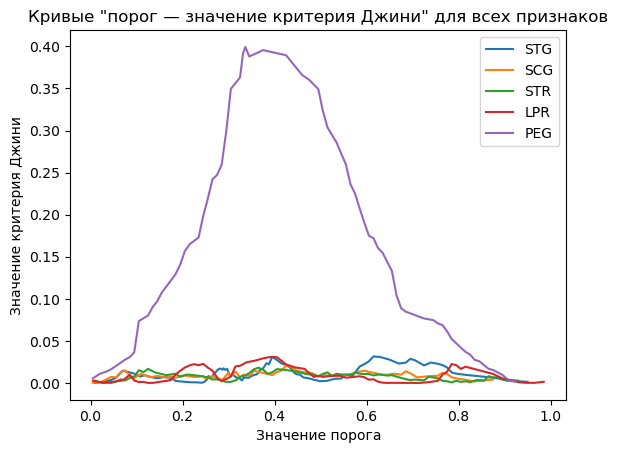

In [16]:
students_df = pd.read_csv('students.csv')

thresholds_dict = {}
ginis_dict = {}

for column in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
    thresholds, ginis, threshold_best, gini_bes = find_best_split(students_df[column], students_df['UNS'])
    thresholds_dict[column] = thresholds
    ginis_dict[column] = ginis

for column in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
    plt.plot(thresholds_dict[column], ginis_dict[column]);

plt.legend(thresholds_dict);
plt.title('Кривые "порог — значение критерия Джини" для всех признаков');
plt.xlabel('Значение порога');
plt.ylabel('Значение критерия Джини');

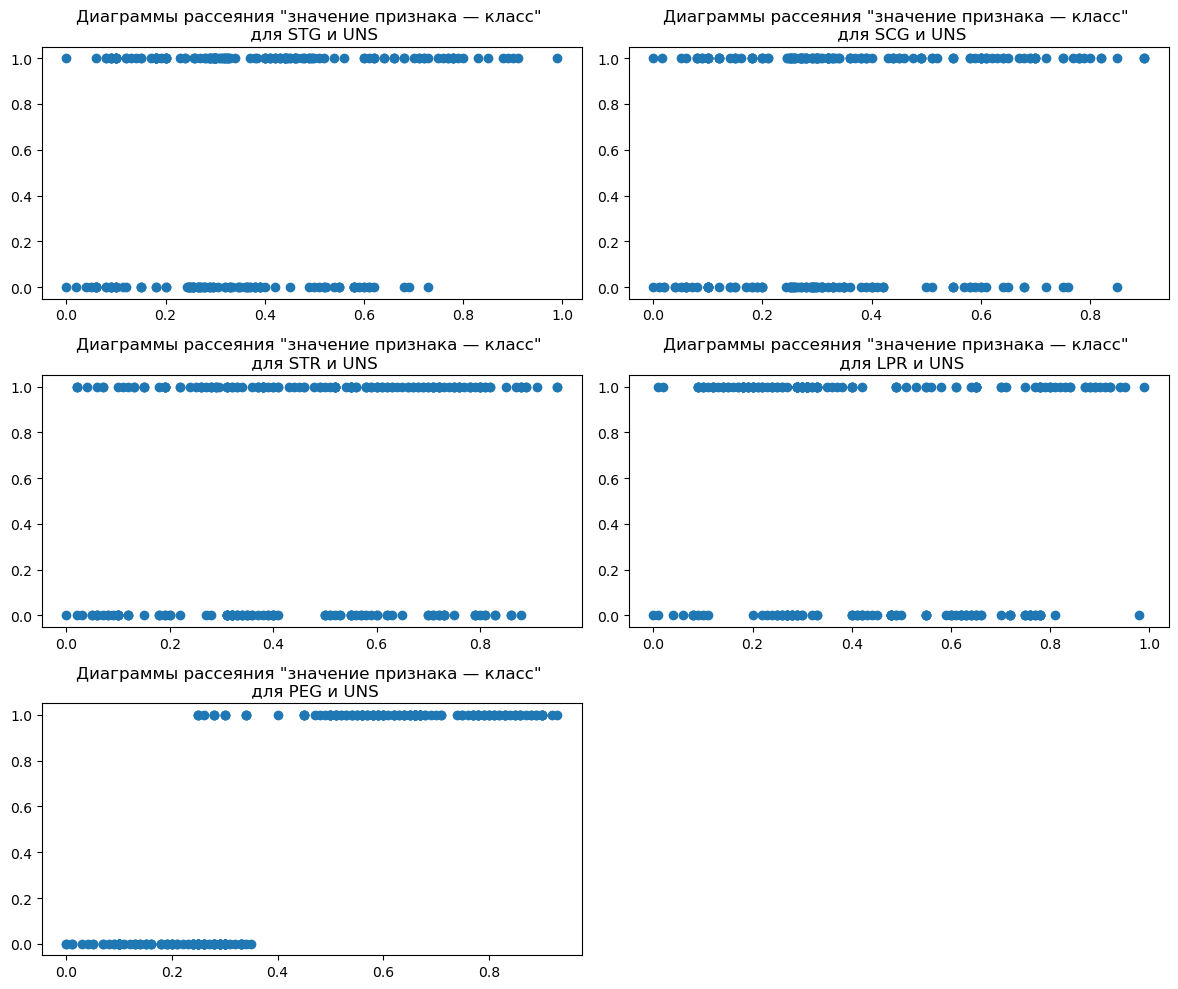

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

axes[0, 0].scatter(students_df['STG'], students_df['UNS']);
axes[0, 0].set_title('Диаграммы рассеяния "значение признака — класс" \n для STG и UNS');

axes[0, 1].scatter(students_df['SCG'], students_df['UNS']);
axes[0, 1].set_title('Диаграммы рассеяния "значение признака — класс" \n для SCG и UNS');

axes[1, 0].scatter(students_df['STR'], students_df['UNS']);
axes[1, 0].set_title('Диаграммы рассеяния "значение признака — класс" \n для STR и UNS');

axes[1, 1].scatter(students_df['LPR'], students_df['UNS']);
axes[1, 1].set_title('Диаграммы рассеяния "значение признака — класс" \n для LPR и UNS');

axes[2, 0].scatter(students_df['PEG'], students_df['UNS']);
axes[2, 0].set_title('Диаграммы рассеяния "значение признака — класс" \n для PEG и UNS');

fig.tight_layout();
fig.delaxes(axes[2, 1]);

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Нужно производить деление по признаку PEG, у него самое большое значение критерия информативности. Это согласуется с диаграмамми рассеивания, так как именно у признака PEG можно заметить, что разное значение признака связано с разными классами. У "хорошего" признака, делящего выборку почти идеально, кривая в какой-то момент достигает очевидного максимума критерия информативности, когда подбирается лучший порог. У признаков, деление по котороым почти невозможно, кривая монотонная и имеет низкое значение критерия информативности, потому что при любом пороге значение критерия информативности плохое.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [74]:
from sklearn.preprocessing import LabelEncoder

mushrooms = pd.read_csv('agaricus-lepiota.data')
le = LabelEncoder()
for col in mushrooms.columns:
    mushrooms[col] = le.fit_transform(mushrooms[col])

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(mushrooms.drop('p', axis=1), mushrooms['p'], random_state=11, test_size=0.5)

In [76]:
feature_types = ('categorical ' * X_train.shape[1]).split()

In [79]:
tree = DecisionTree(feature_types = feature_types)
tree.fit(X_train.values, y_train.values)  
preds = tree.predict(X_test.values)

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, preds)

0.999507631708518

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [96]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [67]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

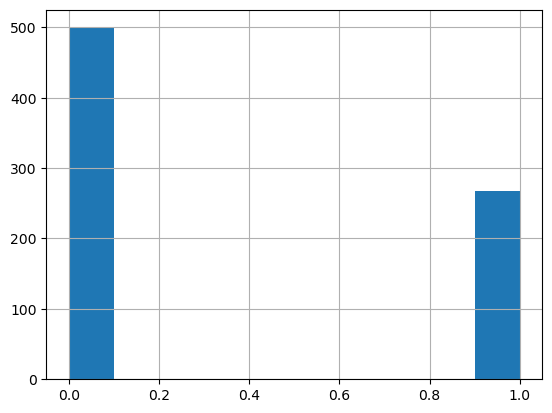

In [68]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [69]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, random_state=11, test_size=0.3)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_1, y_train_1, random_state=11, test_size=0.3)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [83]:
from sklearn.metrics import f1_score

max_depth = [i for i in range(2, 20)]
min_samples_leaf = [i for i in range(2, 20)]

best_max = 0
best_min = 0
f_sc_best = -1

for max_d in max_depth:
    for min_s in min_samples_leaf:
        clf = DecisionTreeClassifier(max_depth = max_d, min_samples_leaf = min_s, random_state=42)
        clf.fit(X_train, y_train)
        pred = clf.predict(X_valid)
        f_sc = f1_score(y_valid, pred)
        if f_sc > f_sc_best:
            best_max = max_d
            best_min = min_s
            f_sc_best = f_sc

In [84]:
best_max, best_min

(10, 5)

In [88]:
clf = DecisionTreeClassifier(max_depth = best_max, min_samples_leaf = best_min, random_state=42)
clf.fit(X_train_1, y_train_1)
preds = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

In [94]:
print(f'accuracy: {accuracy_score(y_test, preds)}')
print(f'precision: {precision_score(y_test, preds)}')
print(f'recall: {recall_score(y_test, preds)}')
print(f'roc_auc_score: {roc_auc_score(y_test, y_score[:, 1])}')

accuracy: 0.7272727272727273
precision: 0.6507936507936508
recall: 0.5
roc_auc_score: 0.7479129153707644


**Итого**, качество классификации довольно хорошее.

**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [97]:
bag = BaggingClassifier(n_estimators=50, n_jobs=4)
bag.fit(X_train_1, y_train_1)

BaggingClassifier(n_estimators=50, n_jobs=4)

In [98]:
preds = bag.predict(X_test)
y_score = bag.predict_proba(X_test)
print(f'accuracy: {accuracy_score(y_test, preds)}')
print(f'precision: {precision_score(y_test, preds)}')
print(f'recall: {recall_score(y_test, preds)}')
print(f'roc_auc_score: {roc_auc_score(y_test, y_score[:, 1])}')

accuracy: 0.7662337662337663
precision: 0.7333333333333333
recall: 0.5365853658536586
roc_auc_score: 0.8470289736454413


**Ответ**: Заметно, что улучшился ROC-AUC и precision, остальные метрики тоже улучшились, но не сильно заметно. 

**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [109]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

max_depth = [i for i in range(2, 20)]
min_samples_leaf = [i for i in range(2, 20)]

best_max = 0
best_min = 0
f_sc_best = -1
f1_scorer = make_scorer(f1_score)

for max_d in max_depth:
    for min_s in min_samples_leaf:
        clf = RandomForestClassifier(n_estimators = 50, max_depth = max_d, min_samples_leaf = min_s, random_state=42)
        clf.fit(X_train_1, y_train_1)
        cross_val = cross_val_score(clf, X_train_1, y_train_1, cv=3, scoring=f1_scorer)
        f_sc = np.mean(cross_val)
        if f_sc > f_sc_best:
            best_max = max_d
            best_min = min_s
            f_sc_best = f_sc

In [111]:
clf = RandomForestClassifier(n_estimators = 50, max_depth = best_max, min_samples_leaf = best_min, random_state=42)
clf.fit(X_train_1, y_train_1)
preds = clf.predict(X_test)
y_score = clf.predict_proba(X_test)
print(f'accuracy: {accuracy_score(y_test, preds)}')
print(f'precision: {precision_score(y_test, preds)}')
print(f'recall: {recall_score(y_test, preds)}')
print(f'roc_auc_score: {roc_auc_score(y_test, y_score[:, 1])}')

accuracy: 0.7878787878787878
precision: 0.7704918032786885
recall: 0.573170731707317
roc_auc_score: 0.845392044524472


**Ответ**: лучше всех показала себя последняя модель (случайный лес), у нее самые хорошие метрики качества классификации.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

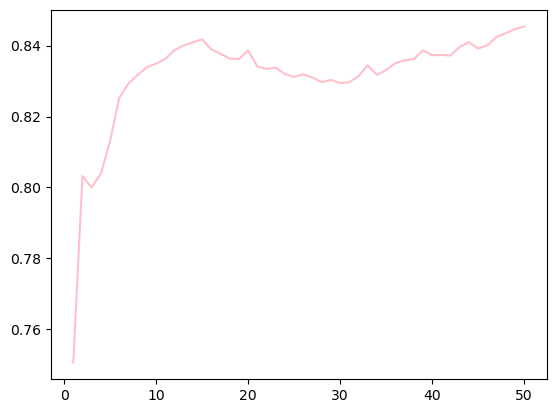

In [113]:
aucs = []

for i in range(1, 51):
        clf = RandomForestClassifier(n_estimators = i, max_depth = best_max, min_samples_leaf = best_min, random_state=42)
        clf.fit(X_train_1, y_train_1)
        y_score = clf.predict_proba(X_test)
        aucs.append(roc_auc_score(y_test, y_score[:, 1]))

plt.plot(range(1, 51), aucs, color='pink');

**Ответ**: мы видим, что при количестве деревьев ~ 15 значение ROC-AUC достигает некоего почти плато, и потом с ростов количества деревьев в случайном лесе значение этой метрики слабо меняется, причем, оно не уменьшается, потому что случайный лес не переобучается.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

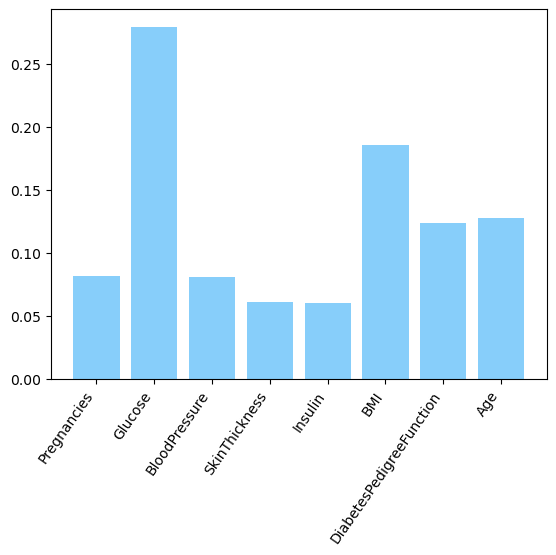

In [130]:
plt.bar(X.columns, clf.feature_importances_, color='lightskyblue');
plt.xticks(rotation=55, ha='right');

**Ответ**: Самым важным оказался признак "Glucose", который, видимо, отвечает за информацию об уровне глюкозы и тп.